In [8]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
cpi=pd.read_csv("inflation-of-consumer-prices.csv")
cpi.head()

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
0,Australia,AUS,1960,3.728814
1,Austria,AUT,1960,1.945749
2,Belgium,BEL,1960,0.299467
3,Bolivia,BOL,1960,11.533153
4,Burkina Faso,BFA,1960,7.788162


           infl      years
23     1.779878 1960-01-01
89     1.695213 1961-01-01
157    3.632215 1962-01-01
227    2.946161 1963-01-01
297   13.355261 1964-01-01
...         ...        ...
8546   3.729506 2019-01-01
8736   6.623437 2020-01-01
8925   5.131407 2021-01-01
9114   6.699034 2022-01-01
9302   5.649143 2023-01-01

[64 rows x 2 columns]


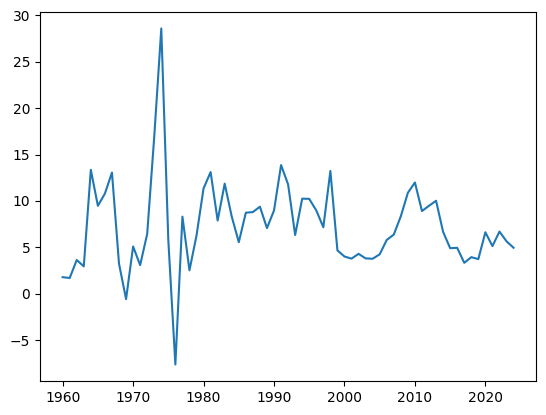

In [9]:

country="India"
data=cpi[cpi["Entity"]==country].sort_values("Year")
cp=data['Inflation, consumer prices (annual %)']
years = pd.to_datetime(data["Year"], format="%Y")
cp.head()
cp.tail()
plt.plot(years, cp)
values=pd.DataFrame({"infl":cp,"years":years})
print(values.iloc[:64])





In [12]:
from statsmodels.tsa.stattools import adfuller

diffrence=cp.dropna()
result1=adfuller(diffrence)
print(result1[0])
print(result1[1])
print({k: round(v, 2) for k, v in result1[4].items()}) 

if result1[1]<0.05:
    print("ok")
else:
    print("not ok")

-5.3051337383864885
5.343157742930871e-06
{'1%': np.float64(-3.54), '5%': np.float64(-2.91), '10%': np.float64(-2.59)}
ok


<function plot_pacf at 0x00000136BC88DE40>
-------------


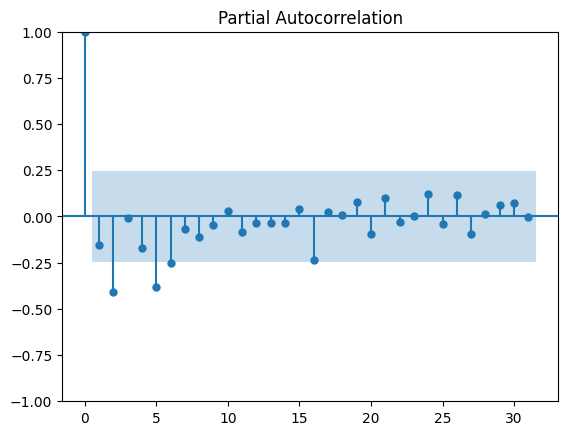

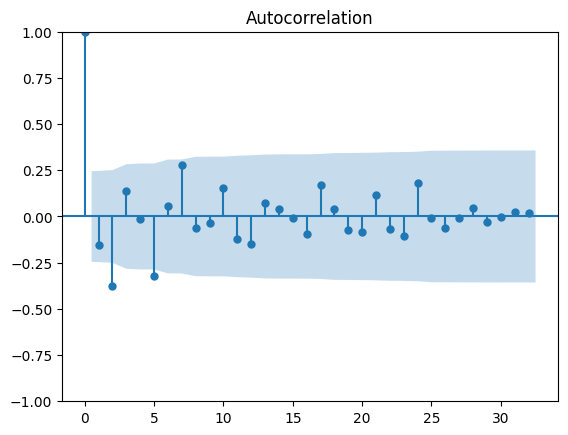

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_pacf(cp.diff().dropna(),lags=31)
plot_acf(cp.diff().dropna(),lags=32)
print(plot_pacf)
print("-------------")
plt.show(plot_acf)





p=1,2,4 q=1,5 (1,0 1) (1,0,5)(2,0,1) (2,0,5 ) (4,0,1 )(4,0,5)

usa (2,1,2) india (p=2,5 d=0,q=2,5)

In [17]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(cp,order=(5,0,5))
res=model.fit()
print(res.summary())

                                         SARIMAX Results                                         
Dep. Variable:     Inflation, consumer prices (annual %)   No. Observations:                   65
Model:                                    ARIMA(5, 0, 5)   Log Likelihood                -181.524
Date:                                   Sat, 11 Oct 2025   AIC                            387.049
Time:                                           11:05:10   BIC                            413.142
Sample:                                                0   HQIC                           397.344
                                                    - 65                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3963      0.658     11.244      0.000    

In [16]:
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse
import pandas as pd
data["Year"]=pd.to_datetime(data["Year"], format="%Y")
X=data[["Year"]]  
y=data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()
p=[2,5]
d=[0]
q=[2,5]
results=[]
for pv in p:
    for dv in d:
        for qv in q:
            X_train,X_test,y_train,y_test=train_test_split(X, y,train_size=0.8,shuffle=False)
            model=ARIMA(y_train,order=(pv,dv,qv))   
            result=model.fit()
            start=len(y_train)
            end=len(y_train)+len(y_test)-1
            predictions = result.predict(start=start, end=end, typ="levels")
            predictions.index = X_test["Year"].values
            fitted_vals=result.fittedvalues
            fitted_vals.index=y_train.index

            trainr = rmse(y_train,fitted_vals)
            testr = rmse(y_test,predictions)
            diff=trainr-testr
            
            results.append((pv,dv,qv,trainr,testr,diff))
            #print(f"Order=({pv},{dv},{qv})Train RMSE:{train_rmse}Test RMSE:{test_rmse:}")
df_results = pd.DataFrame(results,columns=["p","d","q","Trainrmse","TestrmseE","difference"])
print(df_results)

   p  d  q  Trainrmse  TestrmseE  difference
0  2  0  2   4.499928   2.970945    1.528983
1  2  0  5   4.382118   2.797170    1.584947
2  5  0  2   4.268384   3.325030    0.943354
3  5  0  5   4.214128   3.500375    0.713753


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse
import numpy as np
data["Year"]=pd.to_datetime(data["Year"], format="%Y")
X=data[["Year"]]  
y=data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()
p=[1,2,4]
d=[0]
q=[1,5]

results=[]
train_test_sizes=[[0.60,0.1],[0.70,0.1],[ 0.80,0.1],[0.90,0.1]]

temp=[] 
for pv in p:
    for dv in d:
        for qv in q:
            print(f"order({pv},{dv},{qv})")
            print()
            for size1,size2 in train_test_sizes:
                print(f"ttsize({size1},{size2})")
                
                X_train,X_test,y_train,y_test=train_test_split(X, y,train_size=size1,test_size=size2,shuffle=False)
                model=ARIMA(y_train,order=(pv,dv,qv))   
                result=model.fit()
                start=len(y_train)
                end=len(y_train)+len(y_test)-1
                predictions = result.predict(start=start, end=end, typ="levels")
                predictions.index = X_test["Year"].values
                fitted_vals=result.fittedvalues
                fitted_vals.index=y_train.index

                trainr=rmse(y_train,fitted_vals)
                testr=rmse(y_test,predictions)
                diff=trainr-testr
                results.append((pv,dv,qv,trainr,testr,diff))
                temp.append((trainr,testr))
                diff=trainr-testr
                print("rms train",trainr)
                print("rms test",testr)
                print('diff',diff)
                print()
                
            temp_arr=np.array(temp)
            mtrain=np.mean(temp_arr[:,0])
            stdtrain=np.std(temp_arr[:,0])
            mtest=np.mean(temp_arr[:,1])
            stdtest=np.std(temp_arr[:,1])
            print(f"mean trainr{mtrain:.2f},std{stdtrain:.2f}")
            print(f" mean testr{mtest:.2f},std{stdtest:.2f}")
            print("-"*50)

            #print(f"Order=({pv},{dv},{qv})Train RMSE:{train_rmse}Test RMSE:{test_rmse:}")
# df_results = pd.DataFrame(results,columns=["p","d","q","Trainrmse","TestrmseE","difference"])
# print(df_results)
# print()

order(1,0,1)

ttsize(0.6,0.1)
rms train 5.080829007819806
rms test 4.530314415058597
diff 0.5505145927612087

ttsize(0.7,0.1)
rms train 4.961345338183285
rms test 2.540169435937051
diff 2.4211759022462336

ttsize(0.8,0.1)
rms train 4.674121135680682
rms test 2.8771278445808735
diff 1.7969932910998088

ttsize(0.9,0.1)
rms train 4.478991716660696
rms test 2.31383506381252
diff 2.165156652848176

mean trainr4.80,std0.24
 mean testr3.07,std0.87
--------------------------------------------------
order(1,0,5)

ttsize(0.6,0.1)
rms train 4.711366061267024
rms test 5.203304925530117
diff -0.4919388642630924

ttsize(0.7,0.1)
rms train 4.636115338162312
rms test 3.1647088044848215
diff 1.4714065336774902

ttsize(0.8,0.1)
rms train 4.393812759949248
rms test 3.089788955168408
diff 1.3040238047808401

ttsize(0.9,0.1)
rms train 4.2237223375875725
rms test 4.036572385185575
diff 0.18714995240199794

mean trainr4.65,std0.27
 mean testr3.47,std0.95
--------------------------------------------------
ord

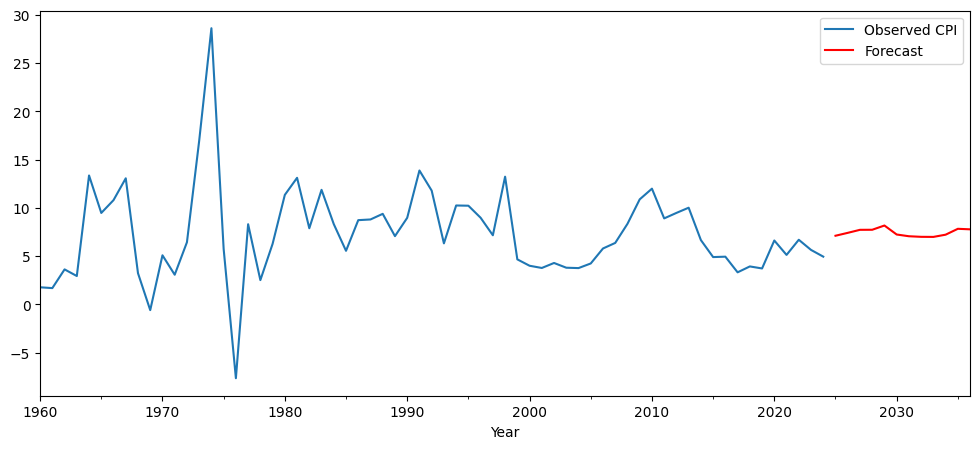

In [18]:
model=ARIMA(y, order=(5,0,5))
result=model.fit()
forecast=result.predict(start=len(y),end=len(y)+12-1,)
last_year=y.index[-1].year
forecast.index=pd.date_range(start=str(last_year+1), periods=12,freq="YE")
#inflation=forecast.pct_change()*100
#inflation.iloc[0] = ((forecast.iloc[0]-y.iloc[-1])/y.iloc[-1])*100
plt.figure(figsize=(12,5))
y.plot(label="Observed CPI")
forecast.plot(label="Forecast", color="red")
#plt.title(f"ARIMA Forecast for {country}")
#plt.xlabel("Year")
#plt.ylabel("CPI (2010=100)")
plt.legend()
plt.show()


In [19]:
forecast_df=pd.DataFrame({"Year":forecast.index,"Forecasted CPI":forecast.values})
print(forecast_df)

         Year  Forecasted CPI
0  2025-12-31        7.115810
1  2026-12-31        7.414903
2  2027-12-31        7.728398
3  2028-12-31        7.735037
4  2029-12-31        8.173862
5  2030-12-31        7.243720
6  2031-12-31        7.063721
7  2032-12-31        7.003719
8  2033-12-31        6.995283
9  2034-12-31        7.226083
10 2035-12-31        7.834204
11 2036-12-31        7.780298
